In [ ]:
# como siempre antes que nada importamos todo
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

Vuelvo a arrancar, ahora directo con Fashion MNIST para el trabajo 3, probablemente el trabajo 4 tambien sea un autoencoder para seguir con lo mismo, de esa forma hay tiempo para este trabajo.

In [ ]:
transform = transforms.ToTensor()
# introducimos los datasets
train_dataset = torchvision.datasets.FashionMNIST(root = "./data" , train = True , download = True ,  transform = transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data" , train = False , download = True ,  transform = transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 17404784.44it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 286179.33it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5591382.84it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16296058.11it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
#declaramos el dataloader y elegimos el batch
batch = 32
dataloader = torch.utils.data.DataLoader(train_dataset , batch_size = batch)
test_dataloader = torch.utils.data.DataLoader(test_dataset , batch_size = batch)

In [ ]:
class Reshape(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args

  def forward(self, x):
    return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self, *args):
    super().__init__()

  def forward(self, x):
    return x[:, :, :28, :28]


In [ ]:
#Ahora podemos definir nuestra red neuronal
capa_interna = 512

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.Flatten(),
        nn.Linear(3136, 64)
    )

  def forward(self, x):
    x = self.conv(x)

    return x

class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.convTrans = nn.Sequential(
        torch.nn.Linear(64, 3136),
        Reshape(-1, 64, 7, 7),
        nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
        nn.LeakyReLU(0.01),
        nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
        Trim(),  # 1x29x29 -> 1x28x28
        nn.Sigmoid()
        )

  def forward(self, x):
    x = self.convTrans(x)
    return x


In [ ]:
##elegimos dispositivo, no me queda claro si esto es necesario o no
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# y mandamos los moodelos al dispositivo
Enc = Encoder().to(device)
Dec = Decoder().to(device)


In [ ]:
# elegimos funcion de error y optimizador
loss_fn = nn.MSELoss()
optimizer_Enc = torch.optim.Adam(Enc.parameters(), lr = 0.001)
optimizer_Dec = torch.optim.Adam(Dec.parameters(), lr = 0.001)

In [ ]:
train_loss = []
test_loss = []

In [ ]:
numero_epocas = 50

In [ ]:
num_batches_test = 10000/batch
num_batches_train = 60000/batch

i = 1
for epoch in range(numero_epocas):
  print(f'Epoch:{i}')
  i = i+1
  train_epoch_loss = 0
  for (imgs , _) in dataloader:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)

    latents = Enc(imgs)
    output = Dec(latents)

    loss = loss_fn(output , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()

    optimizer_Enc.zero_grad()
    optimizer_Dec.zero_grad()

    loss.backward()

    optimizer_Enc.step()
    optimizer_Dec.step()

  train_loss.append(train_epoch_loss/num_batches_train)

  test_epoch_loss = 0
  for (imgs , _) in test_dataloader:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    #imgs = imgs.flatten(1)

    t_loss = loss_fn(Dec(Enc(imgs)),imgs)

    test_epoch_loss += t_loss.cpu().detach().numpy()
  test_loss.append(test_epoch_loss/num_batches_test)

Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50


Aca abajo pongo como guardar y cargar modelos, asi no se pierden.
Recordar que para cargarlos hay que inicializar el modelo primero, con optimzer y toda la cosa


In [ ]:
# Guardemos el modelo asi no tenemos que volver a correrlo
torch.save(Enc.state_dict(), f"Encoder_Conv_32_64_50ep_statedict.pth")
torch.save(Dec.state_dict(), f"Decoder_Conv_32_64_50ep_statedict.pth")

In [ ]:
#model = CNN().to(device)
#
Enc.load_state_dict(torch.load("Encoder_2.pth"))
Dec.load_state_dict(torch.load("Decoder_2.pth"))

TypeError: ignored

Text(0.5, 0, 'Epoca')

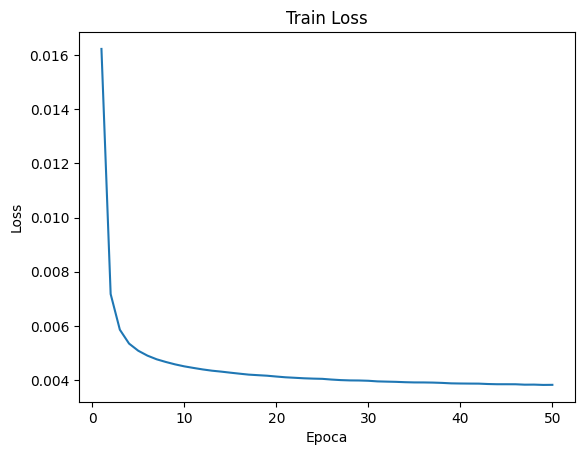

In [ ]:
x = np.arange(1,numero_epocas+1)
plt.plot(x,train_loss)
plt.title("Train Loss")
plt.ylabel("Loss")
plt.xlabel("Epoca")

Text(0.5, 0, 'Epoca')

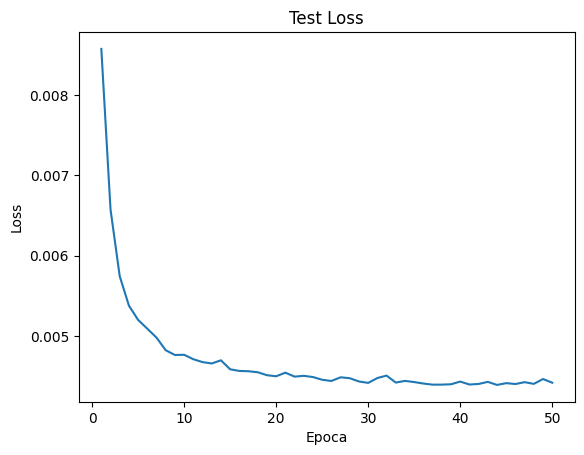

In [ ]:
x = np.arange(1,numero_epocas+1)
plt.plot(x,test_loss)
plt.title("Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoca")

In [ ]:
#guardamos el array
np.savetxt(f'train_loss_{capa_interna}.csv', train_loss)
np.savetxt(f'test_loss_{capa_interna}.csv', test_loss)


#Guardamos en Drive
#file = drive.CreateFile({'Train_loss_Conv64_50ep': train_loss})
#file.SetContentString('\n'.join(train_loss))
#file.Upload()


In [ ]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(10, 2.5), n_images=8, modeltype='autoencoder', nombre="plot_generated_images"):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(Enc(features))[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
    plt.savefig(f"{nombre}.png", dpi =300)


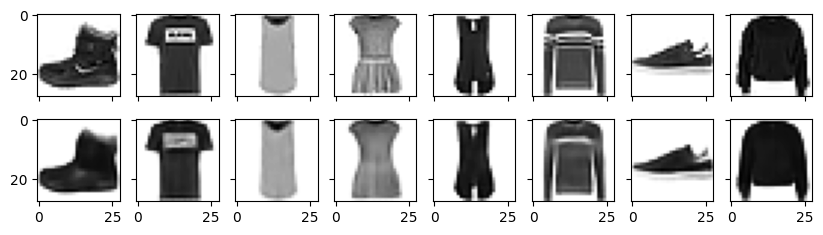

In [ ]:
plot_generated_images(data_loader = dataloader, model = Dec, device = device, nombre="CNN_2lat_50ep")

In [ ]:
Test_lineal = np.loadtxt('test_loss_lineal_512.csv')
Train_lineal = np.loadtxt('train_loss_lineal_512.csv')
Test_Conv = np.loadtxt('test_loss_512.csv')
Train_Conv = np.loadtxt('train_loss_512.csv')

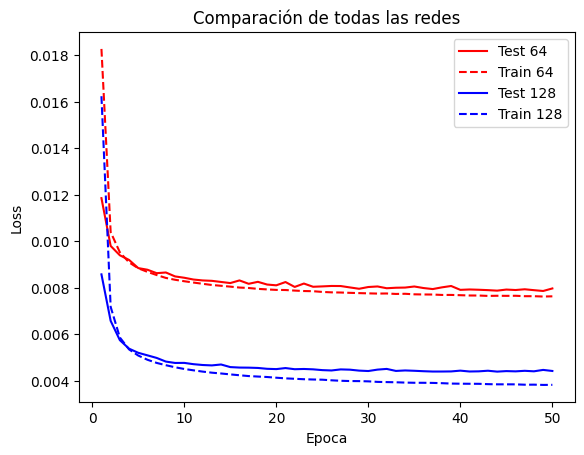

In [ ]:
x = np.arange(1,numero_epocas+1)

plt.plot(x,Test_lineal, label='Test 64',linestyle='-', c='red')
plt.plot(x,Train_lineal, label='Train 64', linestyle='--', c='red')
plt.plot(x,Test_Conv, label='Test 128', linestyle='-', c='blue')
plt.plot(x,Train_Conv, label='Train 128', linestyle='--', c='blue')
plt.plot(plotsize=(12, 6))

plt.title("Comparación de todas las redes")
plt.ylabel("Loss")
plt.xlabel("Epoca")
plt.legend()
plt.savefig("Grafico_todos_Errores.png", dpi =300)
plt.show()